In [119]:
from fenics import *
from mshr import *
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

In [51]:
m, k = 8, 8
mesh = fe.UnitSquareMesh(m, k)
V = fe.FunctionSpace(mesh, 'P', 1)
u_D = fe.Expression('1 + x[0]*x[0] + 2*x[1]*x[1]',
degree=2)
def boundary(x, on_boundary):
    return on_boundary
bc = fe.DirichletBC(V, u_D, boundary)
u = fe.TrialFunction(V)
v = fe.TestFunction(V)
f = fe.Constant(-6.0)
a = fe.dot(fe.grad(u), fe.grad(v))*fe.dx
L = f*v*fe.dx
u = fe.Function(V)
solve(a == L, u, bc)

Solving linear variational problem.


*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.


NameError: name 'interactive' is not defined

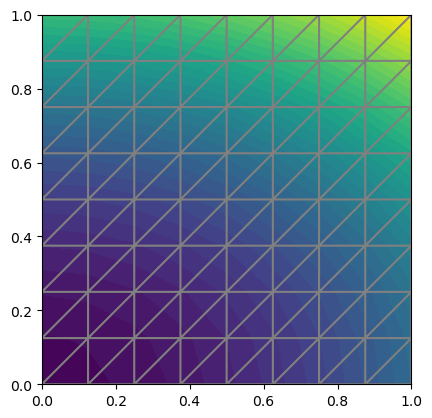

In [57]:
error_L2 = errornorm(u_D, u, 'L2')
vertex_values_u_D = u_D.compute_vertex_values(mesh)
vertex_values_u = u.compute_vertex_values(mesh)
error_C = np.max(np.abs(vertex_values_u - vertex_values_u_D))
plot(u)
plot(mesh)
#vtkfile = File('poisson1_solution.pvd')
#vtkfile << u
interactive()


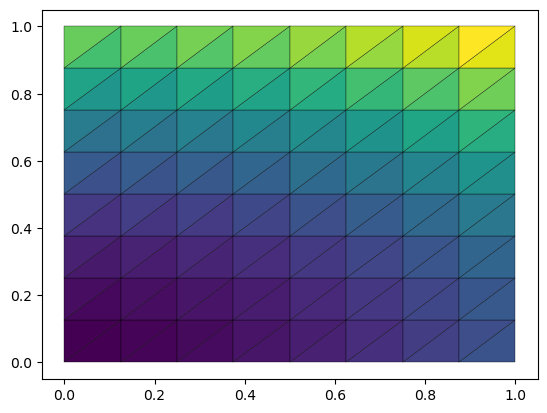

In [71]:
n = mesh.num_vertices()
d = mesh.geometry().dim()
mesh_coordinates = mesh.coordinates().reshape((n,d))
triangles = np.asarray([cell.entities(0) for cell in cells(mesh)])
triangulation = tri.Triangulation(mesh_coordinates[:, 0], mesh_coordinates[:, 1], triangles)
plt.figure()
zfaces = np.asarray([u(cell.midpoint()) for cell in cells(mesh)])
plt.tripcolor(triangulation, facecolors=zfaces, edgecolors='k')
plt.savefig('u_midpoint.png')

In [216]:
def plot_solution(mesh, sol):
    n = mesh.num_vertices()
    d = mesh.geometry().dim()
    mesh_coordinates = mesh.coordinates().reshape((n,d))
    triangles = np.asarray([cell.entities(0) for cell in cells(mesh)])
    triangulation = tri.Triangulation(mesh_coordinates[:, 0], mesh_coordinates[:, 1], triangles)
    plt.figure()
    zfaces = np.asarray([sol(cell.midpoint()) for cell in cells(mesh)])
    plt.tripcolor(triangulation, facecolors=zfaces, edgecolors='k')
    plt.colorbar()
    plt.plot()
    plt.show()
    #plt.savefig('u_midpoint.png')

In [227]:
def plot_save_solution(mesh, sol, name, min, max):
    n = mesh.num_vertices()
    d = mesh.geometry().dim()
    mesh_coordinates = mesh.coordinates().reshape((n,d))
    triangles = np.asarray([cell.entities(0) for cell in cells(mesh)])
    triangulation = tri.Triangulation(mesh_coordinates[:, 0], mesh_coordinates[:, 1], triangles)
    plt.figure()
    zfaces = np.asarray([sol(cell.midpoint()) for cell in cells(mesh)])
    plt.tripcolor(triangulation, facecolors=zfaces, edgecolors='k')
    plt.clim(min, max)
    bounds = np.linspace(min, max, 10)
    plt.colorbar()
    plt.plot()
    #plt.show()
    plt.savefig(f'{name}.png')
    plt.close()

In [218]:
def compute_errors(sol1, sol2, mesh):
    #error_C = np.abs(sol1.vector().get_local() - sol2.vector().get_local()).max()
    error_L2 = errornorm(sol1, sol2, 'L2', mesh=mesh)
    vertex_values_1 = sol1.compute_vertex_values(mesh)
    vertex_values_2 = sol2.compute_vertex_values(mesh)
    error_C = np.max(np.abs(vertex_values_1 - vertex_values_2))
    #print(' t = ', t, ', error_C = ', error_C, ' error_L2 ', error_L2)
    return error_C, error_L2

In [219]:
def solve_basic(alpha, function_space, f, h, g):
    def boundary_D(x, on_boundary):
        return on_boundary and (x[0] < 0)
        
    bc = DirichletBC(function_space, h, boundary)
    
    u = TrialFunction(function_space)
    v = TestFunction(function_space)
    a = dot(grad(u), grad(v))*dx + alpha*u*v*dx
    L = f*v*dx + g*v*ds
    
    u = Function(V)
    solve(a == L, u, bc)
    return u

In [312]:
R = 1
alpha = Constant(1)
domain = Circle(Point(0, 0), R)
mesh = generate_mesh(domain, 16)
V = FunctionSpace(mesh, 'P', 2)

# test 1
#r = Expression("sqrt(x[0] * x[0] + x[1] * x[1])", degree = 2)
#phi = Expression("atan2(x[1], x[0])", degree = 2)
#h = Expression('1 + cos(phi)', phi = phi, degree=2)
#f = Expression('alpha*(1 + r*cos(phi))', alpha = alpha, r = r, phi = phi, degree=2)
#g = Expression('cos(phi)', phi = phi, degree=2)
#analytical_solution = Expression("1 + r*cos(phi)", r = r, phi = phi, degree = 2)

#test 2
r = Expression("sqrt(x[0] * x[0] + x[1] * x[1])", degree = 2)
phi = Expression("atan2(x[1], x[0])", degree = 2)
f = Expression("(alpha*r - 1/r) * sin(phi) * cos(phi)", alpha = alpha, r = r, phi = phi, degree = 2)
h = Expression("sin(phi) * cos(phi)", phi = phi, degree = 2)
g = Expression("sin(phi) * cos(phi)", phi = phi, degree = 2)
analytical_solution = Expression("r * sin(phi) * cos(phi)", r = r, phi = phi, degree = 2)

#test 3
#r = Expression("sqrt(x[0] * x[0] + x[1] * x[1])", degree = 2)
#phi = Expression("atan2(x[1], x[0])", degree = 2)
#f = Expression("sin(phi)*(alpha*r*r - 3)", alpha = alpha, r = r, phi = phi, degree = 2)
#h = Expression("sin(phi)", phi = phi, degree = 2)
#g = Expression("2*sin(phi)", phi = phi, degree = 2)
#analytical_solution = Expression("r*r*sin(phi)", r = r, phi = phi, degree = 2)

u = solve_basic(alpha, V, f, h, g)

Solving linear variational problem.


*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
error_L2  46001617178.523636  error_C  1118674898501.192


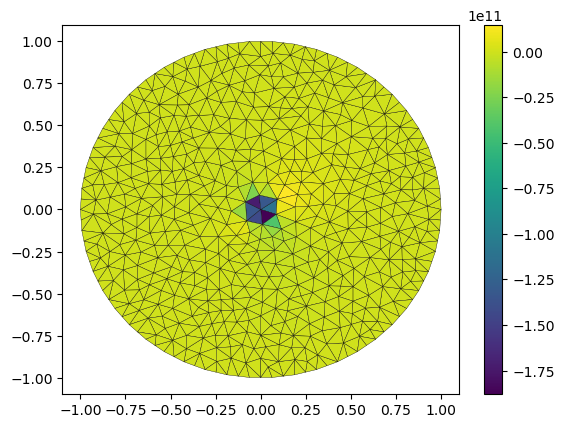

In [313]:
error_C, error_L2 = compute_errors(analytical_solution, u, mesh)
print('error_L2 ', error_L2, ' error_C ', error_C)

plot_solution(mesh, u)
#vtkfile = File('poisson1_solution.pvd')
#vtkfile << u

In [352]:
R = 1
alpha = Constant(1)
domain = Circle(Point(0, 0), R)
mesh = generate_mesh(domain, 10)
V = FunctionSpace(mesh, 'P', 2)

T = 5.0
num_steps = 30
dt = T / num_steps
t = 0
a = 1
r = Expression("sqrt(x[0] * x[0] + x[1] * x[1])", degree = 2)
phi = Expression("atan2(x[1], x[0])", degree = 2)

#task 1
#f = Expression("-r*sin(phi)*sin(t)", t = t, r = r, phi = phi, degree = 2)
#h = Expression("sin(phi)*cos(t)", t = t, phi = phi, degree = 2)
#g = Expression('sin(phi)*cos(t)', t = t, phi = phi, degree=2)
#analytical_solution = Expression("r*sin(phi)*cos(t)", t = t, r = r, phi = phi, degree = 2)
#analytical_funcs = [Expression("r*sin(phi)*cos(t)", t = t, r = r, phi = phi, degree = 2)]

#task 2
#f = Expression("r * cos(phi)", t = t, r = r, phi = phi, degree = 2)
#h = Expression("t * cos(phi) + 1", t = t, phi = phi, degree = 2)
#g = Expression("t * cos(phi)", t = t, phi = phi, degree = 2)
#analytical_solution = Expression("t * r * cos(phi) + 1", t = t, r = r, phi = phi, degree = 2)
#analytical_functions = [Expression("t * r * cos(phi) + 1", t = t, r = r, phi = phi, degree = 2)]

#task 3
f = Expression("cos(t) - 8*r*cos(phi)", t = t, r = r, phi = phi, degree = 2)
h = Expression("cos(phi) + sin(t)", t = t, phi = phi, degree = 2)
g = Expression("3 * cos(phi)", t = t, phi = phi, degree = 2)
analytical_solution = Expression("r*r*r*cos(phi) + sin(t)", t = t, r = r, phi = phi, degree = 2)
analytical_functions = [Expression("r*r*r*cos(phi) + sin(t)", t = t, r = r, phi = phi, degree = 2)]

u_n = interpolate(h, V)
u_n_funcs = [u_n.copy()]
error_list_C = []
error_list_L2 = []

for n in range(num_steps):
    t += dt
    f.t = t
    h.t = t
    g.t = t
    
    u = solve_basic(1/(a * dt), V, f/a + u_n/(a*dt), h, g)
    u_n.assign(u)
    #plot(u)

    #task 1
    #analytical_functions.append(Expression("r*sin(phi)*cos(t)", t = t, r = r, phi = phi, degree = 2))
    #analytical_solution = Expression("r*sin(phi)*cos(t)", t = t, r = r, phi = phi, degree = 2)
    #task 2
    #analytical_functions.append(Expression("t * r * cos(phi) + 1", t = t, r = r, phi = phi, degree = 2)) 
    #analytical_solution = Expression("t * r * cos(phi) + 1", t = t, r = r, phi = phi, degree = 2)
    #task 3
    analytical_functions.append(Expression("r*r*r*cos(phi) + sin(t)", t = t, r = r, phi = phi, degree = 2)) 
    analytical_solution = Expression("r*r*r*cos(phi) + sin(t)", t = t, r = r, phi = phi, degree = 2)
    
    
    u_n_funcs.append(u_n.copy())
    
    errC, errL2 = compute_errors(analytical_solution, u_n, mesh)
    error_list_C.append(errC)
    error_list_L2.append(errL2)

Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in err

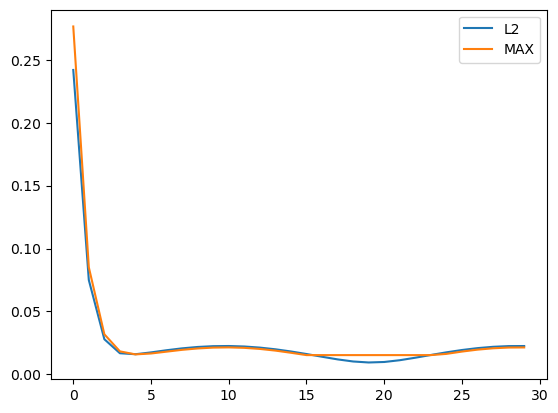

In [353]:
plt.plot(error_list_L2, label='L2')
plt.plot(error_list_C, label='MAX')
plt.legend()
plt.show()

In [354]:
import os
import imageio

#task 1
#a_max = 1.5
#a_min = -2
#n_max = 1.5
#n_min = -2
#
##task 2
#a_max = 7
#a_min = -5
#n_max = 7
#n_min = -5

#task 3
a_max = 3
a_min = -3
n_max = 3
n_min = -3

for i, a_f in enumerate(analytical_functions):
    plot_save_solution(mesh, a_f, f'analytical_{i}', a_min, a_max)

for i, n_f in enumerate(u_n_funcs):
    plot_save_solution(mesh, n_f, f'numerical_{i}', n_min, n_max)

In [355]:
a_imgs = []
with imageio.get_writer("analytical.1.gif", mode = 'i', duration = 0.3) as writer:
    for i in range(num_steps):
        image = imageio.imread(f"analytical_{i}.png")
        a_imgs.append(image)
        writer.append_data(image)
imageio.mimsave('analytical.2.gif', a_imgs)

/tmp/ipykernel_57241/3377050617.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(f"analytical_{i}.png")


In [356]:
with imageio.get_writer("numerical.1.gif", mode = 'i', duration = 0.3) as writer:
    for i in range(num_steps):
        image = imageio.imread(f"numerical_{i}.png")
        writer.append_data(image)

/tmp/ipykernel_57241/569022967.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(f"numerical_{i}.png")
